# Pancreas endocrinogenesis - scVelo E14.5

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import scvelo as scv
import cellrank as cr
from cellrank.kernels import ConnectivityKernel, VelocityKernel
from cellrank.estimators import GPCCA

## General settings

In [3]:
# set verbosity levels
sc.settings.verbosity = 2
cr.settings.verbosity = 4
scv.settings.verbosity = 3

In [4]:
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')

In [5]:
cr.logging.print_versions()

cellrank==1.5.1+g54ada10.d20220713 scanpy==1.9.1 anndata==0.8.0 numpy==1.22.4 numba==0.55.2 scipy==1.8.1 pandas==1.3.5 pygpcca==1.0.3 scikit-learn==1.1.1 statsmodels==0.13.2 python-igraph==0.9.11 scvelo==0.2.5.dev71+g85295fc pygam==0.8.0 matplotlib==3.5.2 seaborn==0.11.2


In [6]:
PROJECT_DIR = Path("/lustre/groups/ml01/projects/2022_neural_ot/")

## Data loading

In [7]:
adata = sc.read(PROJECT_DIR / "adata_pancreas_2019.h5ad")
adata = adata[adata.obs['day'] == '14.5', :].copy()

adata.obsp = {}
adata.uns = {}
adata.obsm = {}
adata.varm = {}
adata.obs = adata.obs.loc[:, ['day', 'celltype']]
adata.var = adata.var[[]]

adata.X = adata.layers['spliced'].copy()

adata

AnnData object with n_obs × n_vars = 9633 × 16206
    obs: 'day', 'celltype'
    layers: 'spliced', 'unspliced'

## Data pre-processing

In [8]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata)

Filtered out 6978 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:02)
computing neighbors
    finished (0:00:15) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [9]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:24)


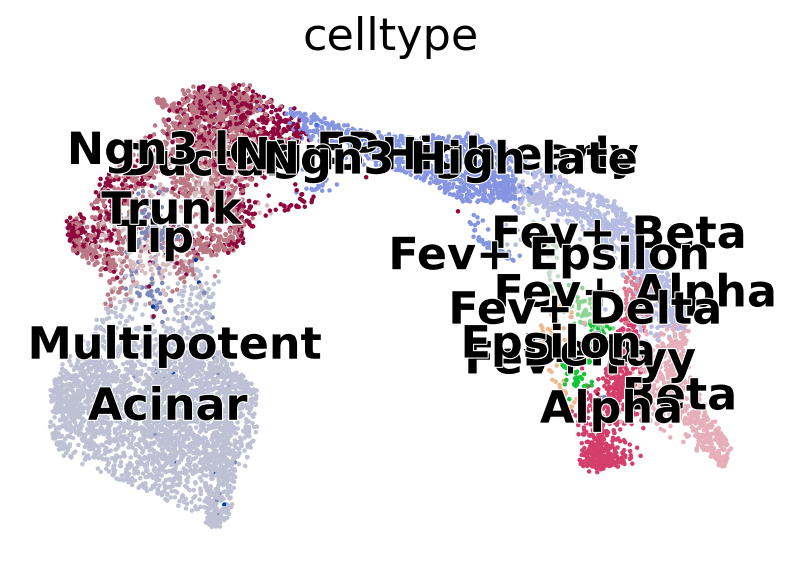

In [10]:
scv.pl.scatter(adata, color='celltype')

## RNA velocity estimation

In [ ]:
scv.tl.recover_dynamics(adata, n_jobs=8)

In [ ]:
scv.tl.velocity(adata, mode='dynamical')

## CellRank

### Transition probabilities

In [ ]:
vk = VelocityKernel(adata).compute_transition_matrix()
ck = ConnectivityKernel(adata).compute_transition_matrix()

combined_kernel = 0.8 * vk + 0.2 * ck

### Macrostate calculation

In [ ]:
g = GPCCA(combined_kernel)

In [ ]:
g.compute_schur(n_components=20)
g.plot_spectrum(real_only=True)

__<span style="color: red;">TODO: Specify number of states</span>__

In [ ]:
g.compute_macrostates(n_states=4, cluster_key="celltype")

In [ ]:
g.plot_macrostates(discrete=True, basis="umap", legend_loc="right", legend_fontweight='normal', legend_fontsize='12', dpi=250)

### Fate probabilities

__<span style="color: red;">TODO: Set terminal states</span>__

In [ ]:
g.set_terminal_states_from_macrostates(
    [
        
    ]
)

In [ ]:
g.compute_absorption_probabilities(solver="gmres", use_petsc=True, time_to_absorption='all')

In [ ]:
g.plot_absorption_probabilities(same_plot=False, basis="umap", perc=[0, 99], ncols=3)

__<span style="color: red;">TODO: Update lineages and clusters</span>__

In [ ]:
cr.pl.aggregate_absorption_probabilities(
    adata,
    mode='heatmap',
    lineages=[],
    cluster_key='celltype',
    clusters=[],
    figsize=(6, 4)
)